<h1>Importing dataset and function definitions</h1>

In [1]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.metrics import roc_curve, auc
%matplotlib inline

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

    
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [2]:
data_train=pd.read_csv("UNSW_NB15_training-set_csc215.csv",na_values=['NA','-'])
data_test=pd.read_csv("UNSW_NB15_test-set_csc215.csv")

In [3]:
def extraction_columns_(data_, cols_to_extract = []):
    '''
    This function removes the unnecessary columns
    that have most values as distinct and unestimable
    '''
    data_extracted = data_.copy(deep = True)
    if cols_to_extract == []:
        data_limiter = 0.35 * data_.shape[0]
        cols_to_extract = list()
        for cols_ in data_.columns:
            if cols_.startswith('ct_') or cols_.startswith('is_'):
                cols_to_extract.append(cols_)
            else:
                nunique_ = data_.loc[:, cols_].nunique()
                print(cols_, str(nunique_))
                if nunique_ >= data_limiter:
                    cols_to_extract.append(cols_)

    data_extracted = data_extracted.drop(cols_to_extract, inplace = False, axis = 1)
    return data_extracted, cols_to_extract


def down_sampling(data_, target = 'label'):
    '''
    This function performs downsampling and make number of records almost equal for label values 0 and 1
    '''
    data_.loc[:, target].value_counts()
    x_tempdatai = data_[data_[target] == 1].index.values
    np.random.shuffle(x_tempdatai)
    x_tempdatai1 = data_[data_[target] == 0].index.values
    criterion_ = min(data_.loc[:, target].value_counts())
    indices_selected = x_tempdatai[0 : criterion_ + 1]
    indices_ = np.append(indices_selected, x_tempdatai1)
    data_ = data_.loc[indices_, :]
    return data_

In [4]:
data_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,NaN,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,NaN,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,NaN,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,NaN,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


<h1>Pre-processing</h1>

In [5]:
data_train.drop(labels=['id','service','state','proto','attack_cat'],axis=1,inplace=True)
data_train.dropna(axis=0,inplace=True)
data_test.drop(labels=['id','service','state','proto','attack_cat'],axis=1,inplace=True)
data_test.dropna(axis=0,inplace=True)

In [6]:
data_train.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,2,1,40,0,0,0,2,39,0,0


In [7]:
data_test.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,...,1,1,2,0,0,0,1,2,0,0
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,...,1,1,2,0,0,0,1,2,0,0
2,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,...,1,1,3,0,0,0,1,3,0,0
3,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,0.0,...,2,1,3,0,0,0,2,3,0,0
4,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,...,2,1,3,0,0,0,2,3,0,0


In [8]:
data_test.columns

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label'],
      dtype='object')

In [9]:
print(data_test.shape)

(82332, 40)


In [10]:
x_trf, columns_ext = extraction_columns_(data_train, [])
x_tef, _ = extraction_columns_(data_test, columns_ext)

dur 74039
spkts 480
dpkts 443
sbytes 7214
dbytes 6660
rate 76991
sttl 11
dttl 6
sload 80885
dload 77474
sloss 409
dloss 370
sinpkt 76161
dinpkt 74245
sjit 77532
djit 76831
swin 13
stcpb 75265
dtcpb 75089
dwin 7
tcprtt 43319
synack 40142
ackdat 37708
smean 1357
dmean 1328
trans_depth 11
response_body_len 2386
label 2


In [11]:
columns_ext

['dur',
 'rate',
 'sload',
 'dload',
 'sinpkt',
 'dinpkt',
 'sjit',
 'djit',
 'stcpb',
 'dtcpb',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'is_sm_ips_ports']

In [12]:
x_trf.shape,x_tef.shape

((175341, 18), (82332, 18))

In [13]:
#x_trf = x_trf.drop_duplicates(subset=x_trf.columns,keep=False)
#x_tef = x_tef.drop_duplicates(subset=x_tef.columns,keep=False)

In [13]:
x_trf.shape,x_tef.shape

((175341, 18), (82332, 18))

In [14]:
print(x_trf.loc[:, 'label'].value_counts())
print(x_tef.loc[:, 'label'].value_counts())

1    119341
0     56000
Name: label, dtype: int64
1    45332
0    37000
Name: label, dtype: int64


In [16]:
x_trf = down_sampling(x_trf, 'label')
#x_tef = down_sampling(x_tef, 'label')

In [17]:
x_trf.shape, x_tef.shape

((112001, 18), (82332, 18))

In [18]:
x_train = x_trf.drop(['label'], axis = 1, inplace=False)
y_train = x_trf.loc[:,'label']
#x_train.reset_index(drop=True)
#y_train.reset_index(drop=True)

In [19]:
x_test = x_tef.drop(['label'], axis = 1, inplace=False)
y_test = x_tef.loc[:,'label']
#x_test.reset_index(drop=True)
#y_test.reset_index(drop=True)

# Co-Relation Analysis

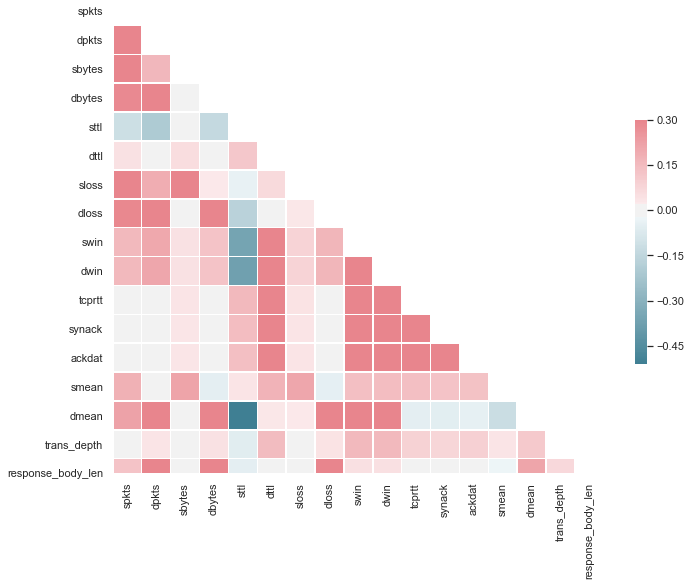

In [20]:
from string import ascii_letters
import seaborn as sns

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                 columns=list(ascii_letters[26:]))
d = x_train
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Normalization using Zscore

In [22]:
for column_name in x_train.columns:
    encode_numeric_zscore(x_train, column_name)
    encode_numeric_zscore(x_test, column_name)

In [23]:
#from sklearn.preprocessing import StandardScaler;
#sc_x=StandardScaler();
#x_train=sc_x.fit_transform(x_train);
#x_test=sc_x.transform(x_test);

In [24]:
x_test.head()

,spkts,dpkts,sbytes,dbytes,sttl,dttl,sloss,dloss,swin,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len
0,-0.124454,-0.151815,-0.043683,-0.087368,0.719436,-0.82039,-0.07353,-0.113243,-1.047913,-1.006238,-0.482022,-0.412907,-0.48407,0.520316,-0.475368,-0.173647,-0.04191
1,-0.124454,-0.151815,-0.036308,-0.087368,0.719436,-0.82039,-0.07353,-0.113243,-1.047913,-1.006238,-0.482022,-0.412907,-0.48407,3.556694,-0.475368,-0.173647,-0.04191
2,-0.124454,-0.151815,-0.040351,-0.087368,0.719436,-0.82039,-0.07353,-0.113243,-1.047913,-1.006238,-0.482022,-0.412907,-0.48407,1.892203,-0.475368,-0.173647,-0.04191
3,-0.124454,-0.151815,-0.041330,-0.087368,0.719436,-0.82039,-0.07353,-0.113243,-1.047913,-1.006238,-0.482022,-0.412907,-0.48407,1.489271,-0.475368,-0.173647,-0.04191
4,-0.124454,-0.151815,-0.034187,-0.087368,0.719436,-0.82039,-0.07353,-0.113243,-1.047913,-1.006238,-0.482022,-0.412907,-0.48407,4.429713,-0.475368,-0.173647,-0.04191


<h1>Logistic Regression</h1>

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cl=LogisticRegression()
cl.fit(x_train,y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
coeff = cl.coef_[0]
coeff

array([ 7.65093962e-01, -1.90769236e+01,  6.30241925e-01, -1.08012337e+01,
        2.24603333e+00,  2.65493957e+00,  8.40477416e+00,  2.86535244e+01,
       -3.99726521e+00,  4.08267903e-01, -1.55077986e-01, -4.82156126e-01,
        2.20570705e-01, -5.48273271e-01,  1.45985658e+00,  1.74020554e+00,
       -4.89466773e-04])

In [27]:
y_pred=cl.predict(x_test)
y_pred

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [28]:
#print(confusion_matrix(y_test, y_pred))

In [29]:
#print(classification_report(y_test,y_pred))

In [30]:
#coeff.shape[0]

In [31]:
#col_to_extract2 = np.where((coeff <= 0.3) & (coeff >= -0.3))
#col_to_extract2[0]

In [32]:
x_train.shape
x_test.shape

(82332, 17)

In [33]:
#x_train = np.delete(x_train.values,col_to_extract2[0],axis=1)
#x_test = np.delete(x_test.values,col_to_extract2[0],axis=1)

In [34]:
#x_train.shape
#x_test.shape

In [35]:
#cl.fit(x_train,y_train)
#coeff = cl.coef_[0]
#coeff

In [36]:
#y_pred=cl.predict(x_test)

In [37]:
#y_pred

[[30945  6055]
 [ 8593 36739]]


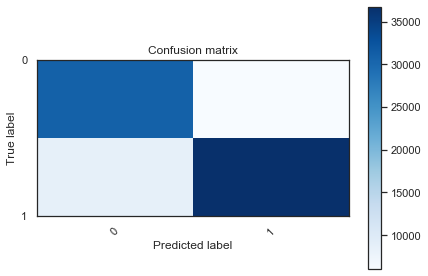

In [38]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81     37000
           1       0.86      0.81      0.83     45332

   micro avg       0.82      0.82      0.82     82332
   macro avg       0.82      0.82      0.82     82332
weighted avg       0.82      0.82      0.82     82332



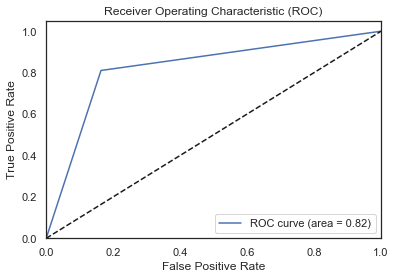

In [40]:
plot_roc(y_pred,y_test)

<h1>SVM</h1>

In [41]:
from sklearn.svm import SVC
svm_object = SVC(kernel = 'rbf')
svm_object.fit(x_train, y_train)
y_pred = svm_object.predict(x_test)

[[24105 12895]
 [ 1192 44140]]


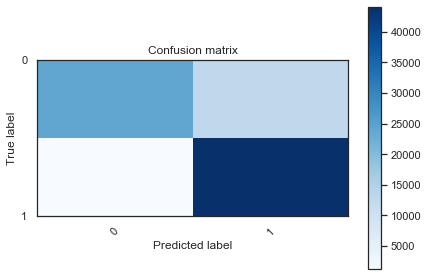

In [42]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.65      0.77     37000
           1       0.77      0.97      0.86     45332

   micro avg       0.83      0.83      0.83     82332
   macro avg       0.86      0.81      0.82     82332
weighted avg       0.85      0.83      0.82     82332



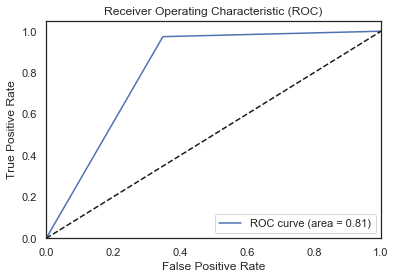

In [44]:
plot_roc(y_pred,y_test)

<h1>KNN</h1>

In [45]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [46]:
y_pred = classifier.predict(x_test)

[[27712  9288]
 [ 3121 42211]]


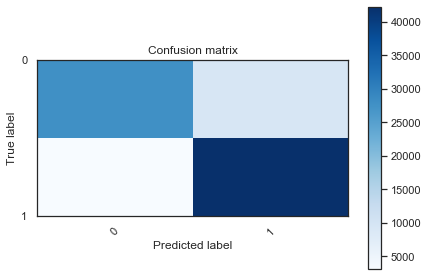

In [47]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82     37000
           1       0.82      0.93      0.87     45332

   micro avg       0.85      0.85      0.85     82332
   macro avg       0.86      0.84      0.84     82332
weighted avg       0.86      0.85      0.85     82332



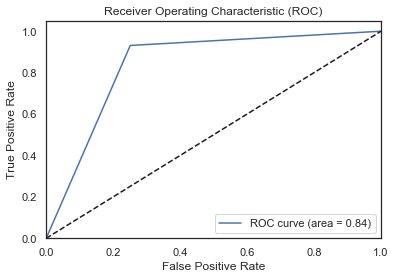

In [49]:
plot_roc(y_pred,y_test)

<h1>Nueral Network</h1>

In [50]:
import os
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [51]:
x_train.values.astype(np.float32)
x_test.values.astype(np.float32)
y_train = to_categorical(y_train)             #don't do again and again
y_test = to_categorical(y_test)            #don't do again and again

In [52]:
y_train,y_test

(array([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32), array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32))

In [53]:

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)

    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(y_train.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='SGD')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=50)

print('Training finished...Loading the best model')  
print()
model.load_weights('best_weights.hdf5')

0
Instructions for updating:
Colocations handled automatically by placer.
Train on 112001 samples, validate on 82332 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 11s - loss: 0.2540 - val_loss: 0.3174
Epoch 2/50
 - 8s - loss: 0.2075 - val_loss: 0.2942
Epoch 3/50
 - 8s - loss: 0.2032 - val_loss: 0.2874
Epoch 4/50
 - 8s - loss: 0.2008 - val_loss: 0.2882
Epoch 5/50
 - 9s - loss: 0.1988 - val_loss: 0.2982
Epoch 6/50
 - 8s - loss: 0.1969 - val_loss: 0.2867
Epoch 7/50
 - 9s - loss: 0.1952 - val_loss: 0.2995
Epoch 8/50
 - 9s - loss: 0.1934 - val_loss: 0.2857
Epoch 9/50
 - 9s - loss: 0.1915 - val_loss: 0.2857
Epoch 10/50
 - 9s - loss: 0.1895 - val_loss: 0.3001
Epoch 11/50
 - 9s - loss: 0.1879 - val_loss: 0.3051
Epoch 12/50
 - 9s - loss: 0.1863 - val_loss: 0.3010
Epoch 13/50
 - 9s - loss: 0.1844 - val_loss: 0.3004
Epoch 00013: early stopping
1
Train on 112001 samples, validate on 82332 samples
Epoch 1/50
 - 9s - loss: 0.2456 - val_loss: 0.3279
Epoch 2/50
 - 9s - loss: 0.

In [54]:
pred = model.predict(x_test)
pred

array([[0.12371175, 0.87628824],
       [0.3147072 , 0.6852928 ],
       [0.56631035, 0.43368965],
       ...,
       [0.99153125, 0.00846881],
       [0.99153125, 0.00846881],
       [0.21853004, 0.78146994]], dtype=float32)

In [55]:
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

[1 1 0 ... 0 0 1]


In [56]:
y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

Accuracy score: 0.8839090511587232


[[27712  9288]
 [ 3121 42211]]


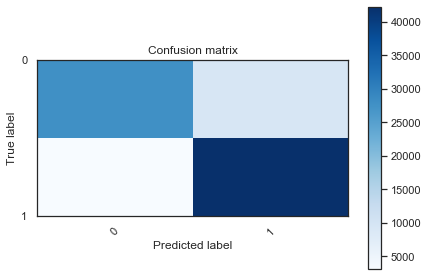

In [58]:
cm = confusion_matrix(y_true,y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [59]:
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

Precision score: 0.8849016557975514


In [60]:
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

Recall score: 0.8839090511587232


In [61]:
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

F1 score: 0.8840904930713561


In [62]:
print(metrics.classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     37000
           1       0.91      0.88      0.89     45332

   micro avg       0.88      0.88      0.88     82332
   macro avg       0.88      0.88      0.88     82332
weighted avg       0.88      0.88      0.88     82332



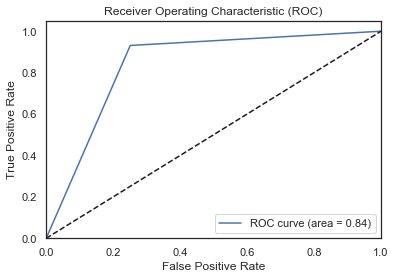

In [63]:
plot_roc(y_pred,y_true)